In [1]:
# Google Colab Only
try:
    import google.colab  # noqa: F401

    %pip install -q dataeval opencv-python-headless torchvision
except Exception:
    pass

In [2]:
from numbers import Number
from typing import cast

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms.v2 as T
from PIL import Image

from dataeval import config
from dataeval.extractors import BoVWExtractor
from dataeval.flags import ImageStats
from dataeval.quality import Duplicates

config.set_seed(42)

In [3]:
def create_textured_image(seed: int, size: int) -> np.ndarray:
    """Create an image with texture patterns that SIFT can detect.

    Returns image in CHW format (3, H, W) with uint8 values.
    """
    rng = np.random.default_rng(seed)

    # Use the seed to generate random frequencies and phases
    # so each seed produces a genuinely different pattern
    freqs = rng.uniform(1.0, 5.0, size=6)
    phases = rng.uniform(0, 2 * np.pi, size=6)
    channel_offsets = rng.integers(5, 30, size=4)

    x = np.linspace(0, 6 * np.pi, size)
    y = np.linspace(0, 6 * np.pi, size)
    xx, yy = np.meshgrid(x, y)

    # Create pattern with seed-dependent frequency components
    pattern = (
        np.sin(xx * freqs[0] + phases[0]) * np.cos(yy * freqs[1] + phases[1])
        + np.sin(xx * freqs[2] + phases[2]) * np.cos(yy * freqs[3] + phases[3]) * 0.5
        + np.sin(xx * freqs[4] + yy * freqs[5] + phases[4]) * 0.3
        + rng.random((size, size)) * 0.2
    )

    # Normalize to 0-255
    pattern = ((pattern - pattern.min()) / (pattern.max() - pattern.min()) * 255).astype(np.uint8)

    # Create RGB image with seed-dependent channel variations
    img = np.stack(
        [
            pattern,
            np.roll(pattern, int(channel_offsets[0]), axis=0),
            np.roll(pattern, int(channel_offsets[1]), axis=1),
        ],
        axis=0,
    )  # Shape: (3, H, W)

    return img.astype(np.uint8)


def numpy_to_pil(img: np.ndarray) -> Image.Image:
    """Convert CHW numpy array to PIL Image."""
    return Image.fromarray(np.transpose(img, (1, 2, 0)))


def pil_to_numpy(img: Image.Image) -> np.ndarray:
    """Convert PIL Image to CHW numpy array."""
    return np.transpose(np.array(img), (2, 0, 1))


def tensor_to_numpy(tensor: torch.Tensor) -> np.ndarray:
    """Convert torch tensor (CHW, float 0-1 or uint8) to CHW numpy uint8."""
    if tensor.dtype == torch.float32:
        tensor = (tensor * 255).to(torch.uint8)
    return tensor.numpy()

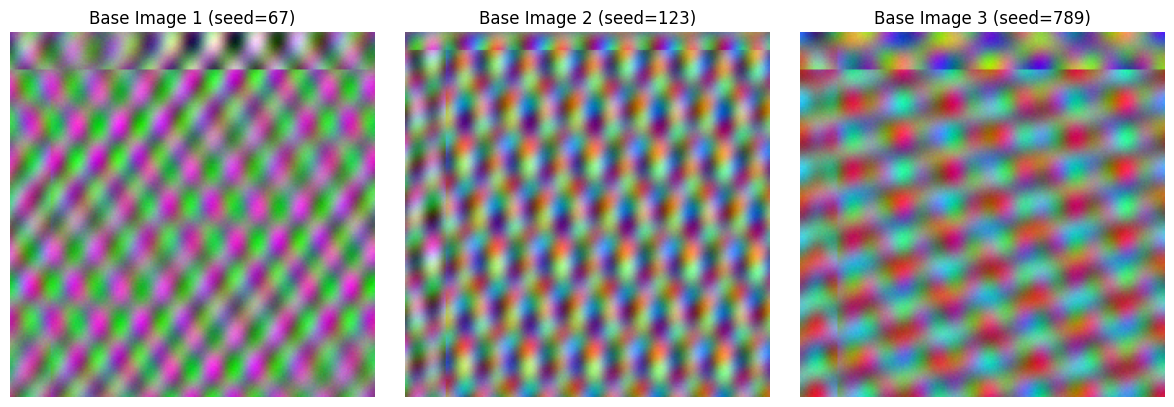

In [4]:
IMG_SIZE = 224

# Create base images
base_img1 = create_textured_image(seed=67, size=IMG_SIZE)
base_img2 = create_textured_image(seed=123, size=IMG_SIZE)
base_img3 = create_textured_image(seed=789, size=IMG_SIZE)

# Display base images
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, (img, title) in enumerate(
    [
        (base_img1, "Base Image 1 (seed=67)"),
        (base_img2, "Base Image 2 (seed=123)"),
        (base_img3, "Base Image 3 (seed=789)"),
    ]
):
    axes[i].imshow(np.transpose(img, (1, 2, 0)))
    axes[i].set_title(title)
    axes[i].axis("off")
plt.tight_layout()
plt.show()

In [5]:
FILL = 128  # Gray fill avoids artificial SIFT edges that black (0) would create


def _n(degrees: int) -> Number:
    """Helper to cast degrees to Number for Pylance."""
    return cast(Number, degrees)


# Helper: rotate with expand=True to preserve full content, then resize back
def _rotate_and_resize(degrees):
    return T.Compose([T.RandomRotation(degrees=(degrees, degrees), expand=True, fill=FILL), T.Resize(IMG_SIZE)])


# Define transformation categories
transformations = {
    # Geometric transformations - SIFT should handle these well
    "Rotation 15°": _rotate_and_resize(15),
    "Rotation 45°": _rotate_and_resize(45),
    "Rotation 90°": _rotate_and_resize(90),
    "Rotation 180°": _rotate_and_resize(180),
    "Horizontal Flip": T.RandomHorizontalFlip(p=1.0),
    "Vertical Flip": T.RandomVerticalFlip(p=1.0),
    "Affine (rotate+translate)": T.RandomAffine(degrees=_n(30), translate=(0.1, 0.1), fill=FILL),
    "Affine (rotate+scale)": T.RandomAffine(degrees=_n(15), scale=(0.8, 1.2), fill=FILL),
    "Perspective (mild)": T.RandomPerspective(distortion_scale=0.2, p=1.0, fill=FILL),
    "Perspective (strong)": T.RandomPerspective(distortion_scale=0.5, p=1.0, fill=FILL),
    # Color transformations - may or may not be detected
    "Brightness +30%": T.ColorJitter(brightness=(1.3, 1.3)),
    "Brightness -30%": T.ColorJitter(brightness=(0.7, 0.7)),
    "Contrast +50%": T.ColorJitter(contrast=(1.5, 1.5)),
    "Saturation +50%": T.ColorJitter(saturation=(1.5, 1.5)),
    "Hue Shift": T.ColorJitter(hue=(0.3, 0.3)),
    "Full ColorJitter": T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    "Grayscale": T.Grayscale(num_output_channels=3),
    "Color Invert": T.RandomInvert(p=1.0),
    # Blur and noise
    "Gaussian Blur (mild)": T.GaussianBlur(kernel_size=5, sigma=(1.0, 1.0)),
    "Gaussian Blur (strong)": T.GaussianBlur(kernel_size=11, sigma=(3.0, 3.0)),
    # Crop and resize
    "Center Crop (80%)": T.Compose([T.CenterCrop(180), T.Resize(IMG_SIZE)]),
    "Center Crop (50%)": T.Compose([T.CenterCrop(112), T.Resize(IMG_SIZE)]),
    "Random Crop (80%)": T.Compose([T.RandomCrop(180), T.Resize(IMG_SIZE)]),
    "Resize Down+Up": T.Compose([T.Resize(112), T.Resize(IMG_SIZE)]),
    "Resize Down+Up (severe)": T.Compose([T.Resize(56), T.Resize(IMG_SIZE)]),
    # Severe transformations - likely to break detection
    "Random Erasing (10%)": T.RandomErasing(p=1.0, scale=(0.02, 0.1)),
    "Random Erasing (33%)": T.RandomErasing(p=1.0, scale=(0.2, 0.33)),
    # Combinations (common augmentation pipelines)
    "Augment: Flip+Rotate": T.Compose(
        [
            T.RandomHorizontalFlip(p=1.0),
            T.RandomRotation(degrees=_n(15), expand=True, fill=FILL),
            T.Resize(IMG_SIZE),
        ]
    ),
    "Augment: Flip+Color": T.Compose(
        [
            T.RandomHorizontalFlip(p=1.0),
            T.ColorJitter(brightness=0.2, contrast=0.2),
        ]
    ),
    "Augment: Full Pipeline": T.Compose(
        [
            T.RandomHorizontalFlip(p=0.5),
            T.RandomRotation(degrees=_n(10), expand=True, fill=FILL),
            T.Resize(IMG_SIZE),
            T.ColorJitter(brightness=0.1, contrast=0.1),
            T.GaussianBlur(kernel_size=3, sigma=(0.5, 0.5)),
        ]
    ),
}

In [6]:
# Apply all transformations to base image 1
images = []
labels = []

# Add original images first
images.append(base_img1)
labels.append("Original (Base 1)")

# Apply each transformation to base image 1
base_pil = numpy_to_pil(base_img1)

for name, transform in transformations.items():
    torch.manual_seed(42)  # For reproducibility
    transformed = transform(base_pil)
    images.append(pil_to_numpy(transformed))
    labels.append(name)

# Add other base images as "unique" images (should NOT be detected as duplicates)
images.append(base_img2)
labels.append("Unique: Base 2")
images.append(base_img3)
labels.append("Unique: Base 3")

print(f"Created {len(images)} test images:")
print(f"  - {1} original")
print(f"  - {len(transformations)} transformations")
print(f"  - {2} unique (different base images)")

Created 33 test images:
  - 1 original
  - 30 transformations
  - 2 unique (different base images)


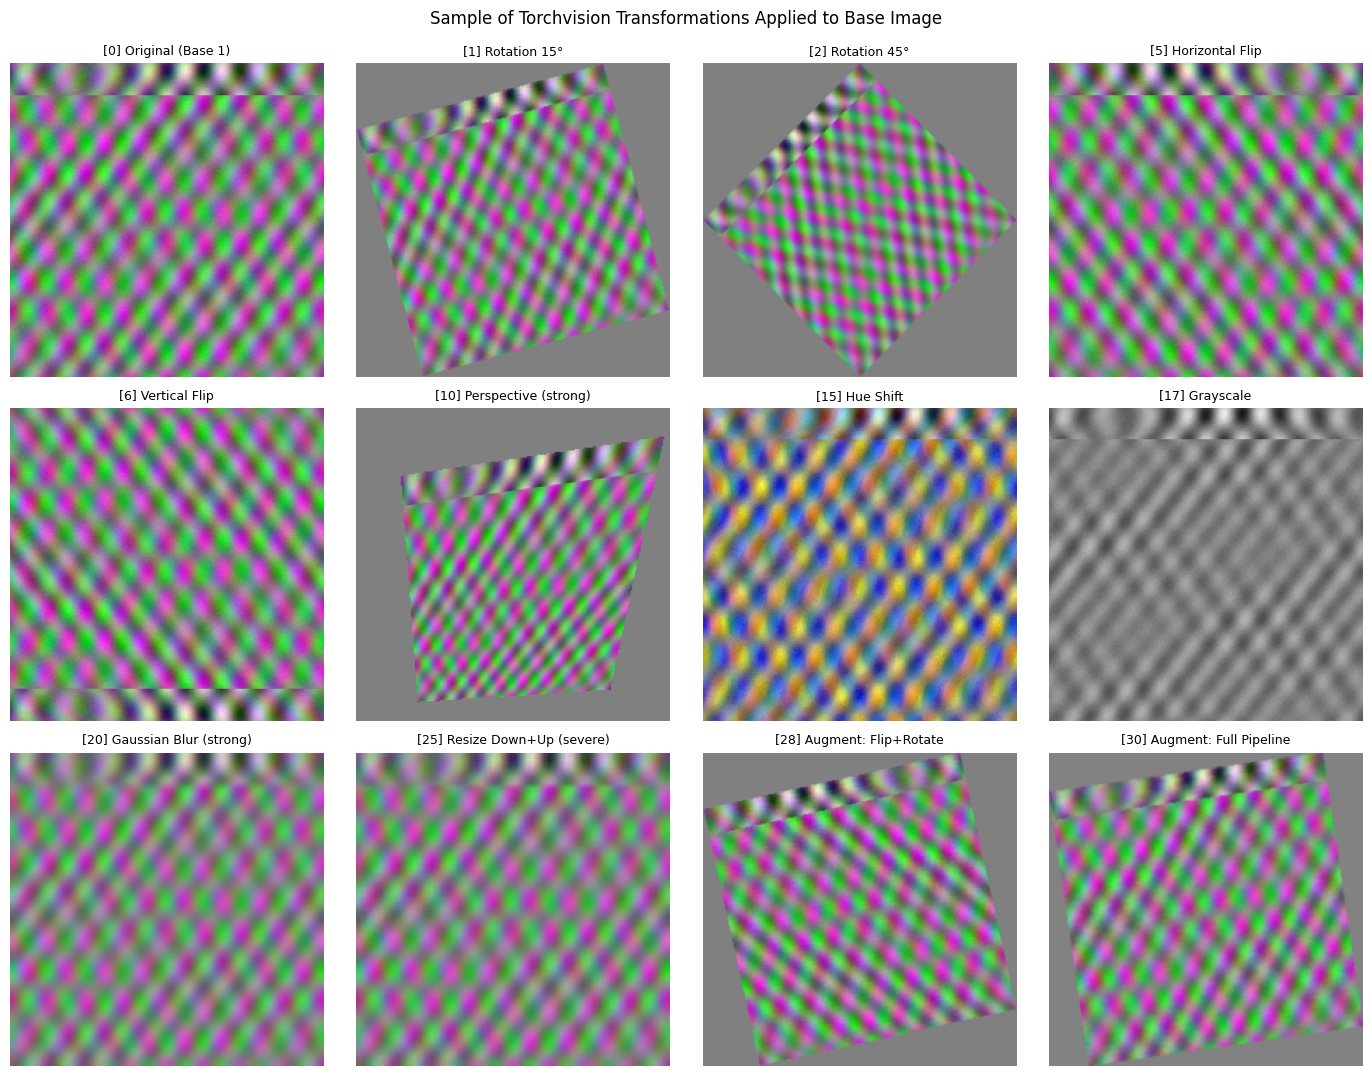

In [7]:
# Visualize a sample of transformations
sample_indices = [0, 1, 2, 5, 6, 10, 15, 17, 20, 25, 28, 30]
sample_indices = [i for i in sample_indices if i < len(images)]

n_cols = 4
n_rows = (len(sample_indices) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 3.5 * n_rows))
axes = axes.flatten()

for ax_idx, img_idx in enumerate(sample_indices):
    img = images[img_idx]
    axes[ax_idx].imshow(np.transpose(img, (1, 2, 0)))
    axes[ax_idx].set_title(f"[{img_idx}] {labels[img_idx]}", fontsize=9)
    axes[ax_idx].axis("off")

for i in range(len(sample_indices), len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.suptitle("Sample of Torchvision Transformations Applied to Base Image", y=1.02, fontsize=12)
plt.show()

In [8]:
# Method 1: D4 Hash-based detection (rotation/flip invariant at 90° increments)
d4_detector = Duplicates(flags=ImageStats.HASH_DUPLICATES_D4)
d4_results = d4_detector.evaluate(images)

print("=== D4 Hash Results ===")
print("\nNear duplicates detected:")
if d4_results.items.near:
    for group in d4_results.items.near:
        indices = [i[0] if isinstance(i, tuple) else i for i in group.indices]
        print(f"  Group: {indices}")
        print(f"    Labels: {[labels[i] for i in indices]}")
        print(f"    Methods: {sorted(group.methods)}")
        print()
else:
    print("  None found")

=== D4 Hash Results ===

Near duplicates detected:
  Group: [0, 3, 4, 5, 6, 12, 14, 18, 19, 20]
    Labels: ['Original (Base 1)', 'Rotation 90°', 'Rotation 180°', 'Horizontal Flip', 'Vertical Flip', 'Brightness -30%', 'Saturation +50%', 'Color Invert', 'Gaussian Blur (mild)', 'Gaussian Blur (strong)']
    Methods: ['dhash_d4', 'phash_d4']

  Group: [17, 25]
    Labels: ['Grayscale', 'Resize Down+Up (severe)']
    Methods: ['dhash_d4']



In [9]:
# Method 2: BoVW-based detection (rotation invariant at any angle)
# Use a smaller vocab_size for this small dataset (~32 images).
# Large vocabularies create sparse histograms that cluster poorly.
bovw_extractor = BoVWExtractor(vocab_size=32)
cluster_threshold = 1.75

bovw_detector = Duplicates(
    flags=ImageStats.NONE,  # Skip hash computation, use only clustering
    extractor=bovw_extractor,
    cluster_threshold=cluster_threshold,
)
bovw_results = bovw_detector.evaluate(images)

print("=== BoVW Results ===")
print("\nNear duplicates detected:")
if bovw_results.items.near:
    for group in bovw_results.items.near:
        indices = [i[0] if isinstance(i, tuple) else i for i in group.indices]
        print(f"  Group: {indices}")
        print(f"    Labels: {[labels[i] for i in indices]}")
        print()
else:
    print("  None found")

=== BoVW Results ===

Near duplicates detected:
  Group: [0, 1, 2, 3, 4, 7, 9, 10, 11, 13, 14, 17, 18, 19, 24, 30]
    Labels: ['Original (Base 1)', 'Rotation 15°', 'Rotation 45°', 'Rotation 90°', 'Rotation 180°', 'Affine (rotate+translate)', 'Perspective (mild)', 'Perspective (strong)', 'Brightness +30%', 'Contrast +50%', 'Saturation +50%', 'Grayscale', 'Color Invert', 'Gaussian Blur (mild)', 'Resize Down+Up', 'Augment: Full Pipeline']

  Group: [5, 6, 28, 29]
    Labels: ['Horizontal Flip', 'Vertical Flip', 'Augment: Flip+Rotate', 'Augment: Flip+Color']

  Group: [20, 25]
    Labels: ['Gaussian Blur (strong)', 'Resize Down+Up (severe)']



In [10]:
# Method 3: Combined detection (both hashes and BoVW)
combined_detector = Duplicates(
    flags=ImageStats.HASH_DUPLICATES_D4,
    extractor=bovw_extractor,
    cluster_threshold=cluster_threshold,
)
combined_results = combined_detector.evaluate(images)

print("=== Combined (D4 Hash + BoVW) Results ===")
print("\nNear duplicates detected:")
if combined_results.items.near:
    for group in combined_results.items.near:
        indices = [i[0] if isinstance(i, tuple) else i for i in group.indices]
        print(f"  Group: {indices}")
        print(f"    Labels: {[labels[i] for i in indices]}")
        print(f"    Methods: {sorted(group.methods)}")
        print()
else:
    print("  None found")

=== Combined (D4 Hash + BoVW) Results ===

Near duplicates detected:
  Group: [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 24, 25, 28, 29, 30]
    Labels: ['Original (Base 1)', 'Rotation 15°', 'Rotation 45°', 'Rotation 90°', 'Rotation 180°', 'Horizontal Flip', 'Vertical Flip', 'Affine (rotate+translate)', 'Perspective (mild)', 'Perspective (strong)', 'Brightness +30%', 'Brightness -30%', 'Contrast +50%', 'Saturation +50%', 'Grayscale', 'Color Invert', 'Gaussian Blur (mild)', 'Gaussian Blur (strong)', 'Resize Down+Up', 'Resize Down+Up (severe)', 'Augment: Flip+Rotate', 'Augment: Flip+Color', 'Augment: Full Pipeline']
    Methods: ['cluster', 'dhash_d4', 'phash_d4']



In [11]:
def get_detected_indices(results):
    """Extract all indices detected as duplicates of index 0 (original)."""
    detected = set()
    if results.items.near:
        for group in results.items.near:
            if 0 in group.indices:  # Group contains the original
                detected.update(group.indices)
    detected.discard(0)  # Remove the original itself
    return detected


d4_detected = get_detected_indices(d4_results)
bovw_detected = get_detected_indices(bovw_results)
combined_detected = get_detected_indices(combined_results)

print("Detection Summary:")
print(f"  D4 Hashes detected: {len(d4_detected)} transformations")
print(f"  BoVW detected: {len(bovw_detected)} transformations")
print(f"  Combined detected: {len(combined_detected)} transformations")

Detection Summary:
  D4 Hashes detected: 9 transformations
  BoVW detected: 15 transformations
  Combined detected: 22 transformations


In [12]:
# Create a detailed comparison table
print("\nDetailed Detection Results:")
print("=" * 70)
print(f"{'Transformation':<35} {'D4 Hash':<10} {'BoVW':<10} {'Combined':<10}")
print("=" * 70)

# Skip index 0 (original) and last 2 (unique images)
for i in range(1, len(images) - 2):
    d4_status = "Yes" if i in d4_detected else "No"
    bovw_status = "Yes" if i in bovw_detected else "No"
    combined_status = "Yes" if i in combined_detected else "No"
    print(f"{labels[i]:<35} {d4_status:<10} {bovw_status:<10} {combined_status:<10}")

print("=" * 70)

# Check unique images (should NOT be detected)
print("\nUnique Image Verification (should NOT be detected):")
for i in range(len(images) - 2, len(images)):
    d4_status = "DETECTED" if i in d4_detected else "OK"
    bovw_status = "DETECTED" if i in bovw_detected else "OK"
    combined_status = "DETECTED" if i in combined_detected else "OK"
    print(f"  {labels[i]}: D4={d4_status}, BoVW={bovw_status}, Combined={combined_status}")


Detailed Detection Results:
Transformation                      D4 Hash    BoVW       Combined  
Rotation 15°                        No         Yes        Yes       
Rotation 45°                        No         Yes        Yes       
Rotation 90°                        Yes        Yes        Yes       
Rotation 180°                       Yes        Yes        Yes       
Horizontal Flip                     Yes        No         Yes       
Vertical Flip                       Yes        No         Yes       
Affine (rotate+translate)           No         Yes        Yes       
Affine (rotate+scale)               No         No         No        
Perspective (mild)                  No         Yes        Yes       
Perspective (strong)                No         Yes        Yes       
Brightness +30%                     No         Yes        Yes       
Brightness -30%                     Yes        No         Yes       
Contrast +50%                       No         Yes        Yes       
Satur

In [13]:
# Categorize results
detected_by_both = bovw_detected & d4_detected
detected_by_bovw_only = bovw_detected - d4_detected
detected_by_d4_only = d4_detected - bovw_detected
missed_by_both = set(range(1, len(images) - 2)) - bovw_detected - d4_detected

print("Categorized Results:")
print(f"\nDetected by BOTH D4 and BoVW ({len(detected_by_both)}):")
for i in sorted(detected_by_both):
    print(f"  [{i}] {labels[i]}")

print(f"\nDetected by BoVW ONLY ({len(detected_by_bovw_only)}):")
for i in sorted(detected_by_bovw_only):
    print(f"  [{i}] {labels[i]}")

print(f"\nDetected by D4 ONLY ({len(detected_by_d4_only)}):")
for i in sorted(detected_by_d4_only):
    print(f"  [{i}] {labels[i]}")

print(f"\nMissed by BOTH ({len(missed_by_both)}):")
for i in sorted(missed_by_both):
    print(f"  [{i}] {labels[i]}")

Categorized Results:

Detected by BOTH D4 and BoVW (5):
  [3] Rotation 90°
  [4] Rotation 180°
  [14] Saturation +50%
  [18] Color Invert
  [19] Gaussian Blur (mild)

Detected by BoVW ONLY (10):
  [1] Rotation 15°
  [2] Rotation 45°
  [7] Affine (rotate+translate)
  [9] Perspective (mild)
  [10] Perspective (strong)
  [11] Brightness +30%
  [13] Contrast +50%
  [17] Grayscale
  [24] Resize Down+Up
  [30] Augment: Full Pipeline

Detected by D4 ONLY (4):
  [5] Horizontal Flip
  [6] Vertical Flip
  [12] Brightness -30%
  [20] Gaussian Blur (strong)

Missed by BOTH (11):
  [8] Affine (rotate+scale)
  [15] Hue Shift
  [16] Full ColorJitter
  [21] Center Crop (80%)
  [22] Center Crop (50%)
  [23] Random Crop (80%)
  [25] Resize Down+Up (severe)
  [26] Random Erasing (10%)
  [27] Random Erasing (33%)
  [28] Augment: Flip+Rotate
  [29] Augment: Flip+Color


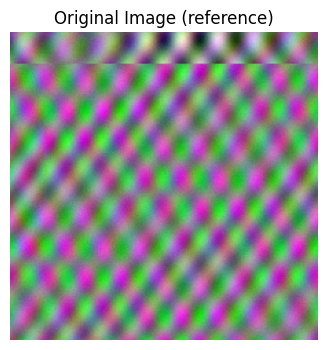

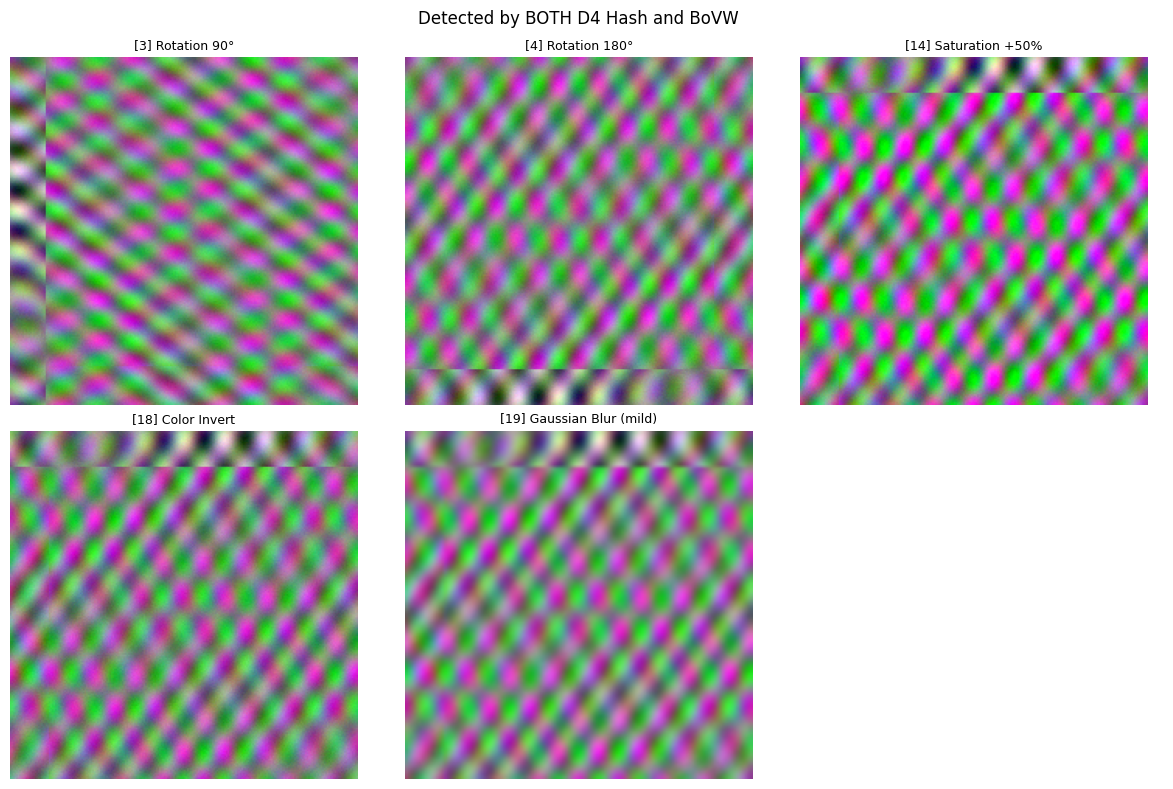

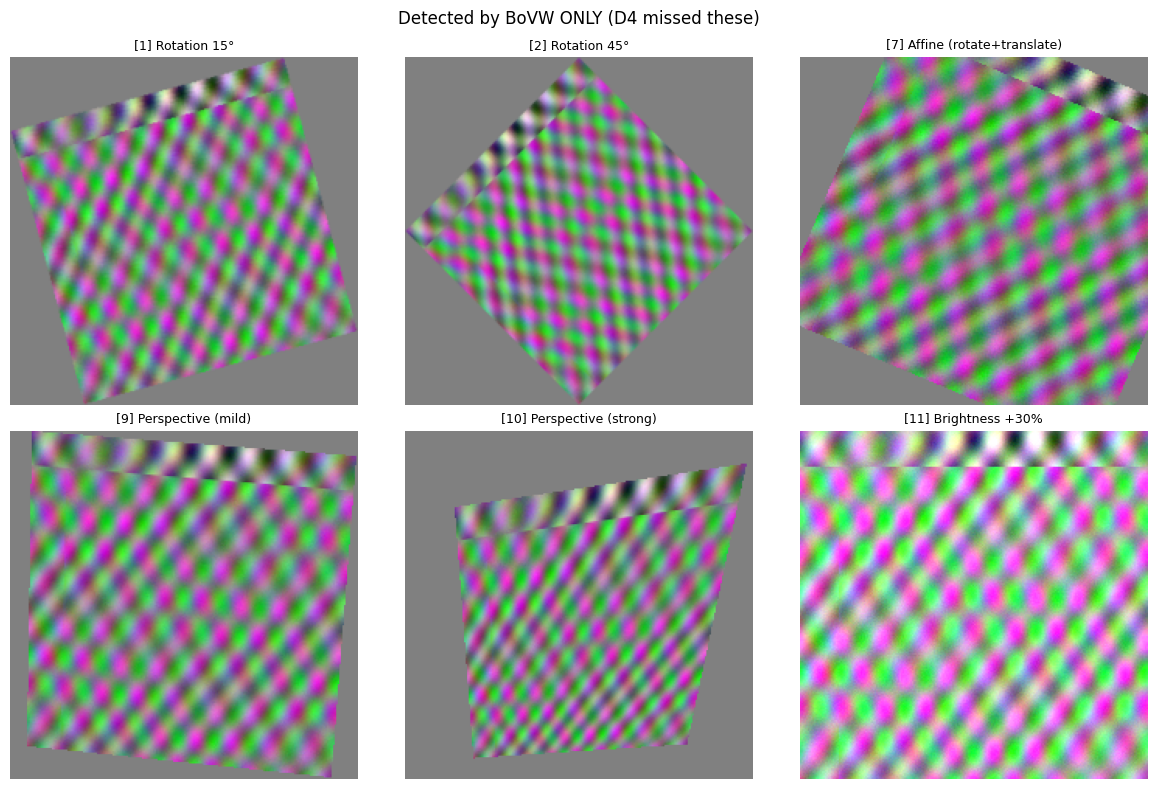

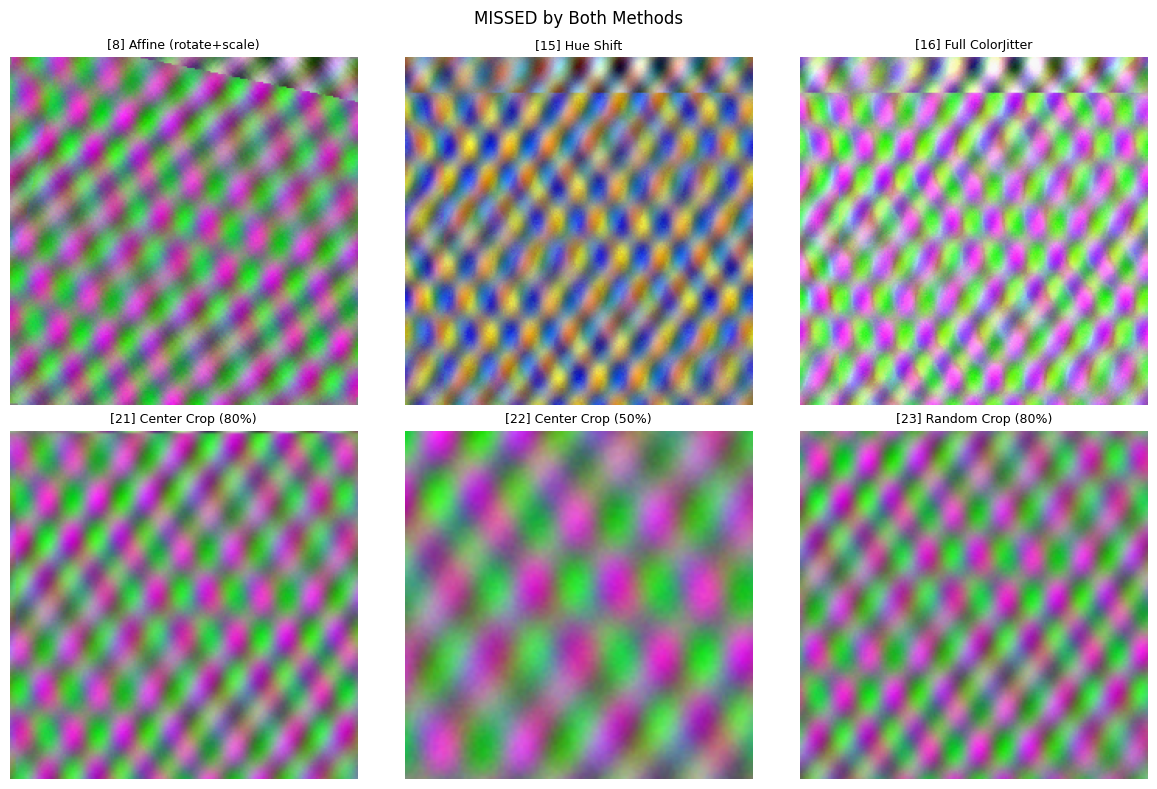

In [14]:
# Visualize some of the detected and missed transformations
def visualize_category(indices, title, max_display=6):
    """Visualize images in a category."""
    if not indices:
        print(f"{title}: No images")
        return

    indices = sorted(indices)[:max_display]
    n_cols = min(len(indices), 3)
    n_rows = (len(indices) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
    axes = [axes] if n_rows * n_cols == 1 else axes.flatten()

    for ax_idx, img_idx in enumerate(indices):
        axes[ax_idx].imshow(np.transpose(images[img_idx], (1, 2, 0)))
        axes[ax_idx].set_title(f"[{img_idx}] {labels[img_idx]}", fontsize=9)
        axes[ax_idx].axis("off")

    for i in range(len(indices), len(axes)):
        axes[i].axis("off")

    plt.suptitle(title, fontsize=12)
    plt.tight_layout()
    plt.show()


# Show original for reference
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.imshow(np.transpose(images[0], (1, 2, 0)))
ax.set_title("Original Image (reference)", fontsize=12)
ax.axis("off")
plt.show()

# Show each category
visualize_category(detected_by_both, "Detected by BOTH D4 Hash and BoVW")
visualize_category(detected_by_bovw_only, "Detected by BoVW ONLY (D4 missed these)")
visualize_category(missed_by_both, "MISSED by Both Methods")

In [15]:
# Test different cluster thresholds
thresholds = [0.75, 1.0, 1.5, 2.0, 2.5]
threshold_results = {}

for threshold in thresholds:
    detector = Duplicates(
        flags=ImageStats.NONE,
        extractor=bovw_extractor,
        cluster_threshold=threshold,
    )
    results = detector.evaluate(images)
    detected = get_detected_indices(results)
    threshold_results[threshold] = detected
    print(f"Threshold {threshold}: {len(detected)} transformations detected")

Threshold 0.75: 0 transformations detected


Threshold 1.0: 3 transformations detected


Threshold 1.5: 6 transformations detected


Threshold 2.0: 17 transformations detected


Threshold 2.5: 22 transformations detected


In [16]:
# Show how detection changes with threshold
print("\nTransformations detected at each threshold:")
print("=" * 90)
header = f"{'Transformation':<35}"
for t in thresholds:
    header += f" {t:<8}"
print(header)
print("=" * 90)

for i in range(1, len(images) - 2):
    row = f"{labels[i]:<35}"
    for t in thresholds:
        status = "Yes" if i in threshold_results[t] else "-"
        row += f" {status:<8}"
    print(row)

print("=" * 90)


Transformations detected at each threshold:
Transformation                      0.75     1.0      1.5      2.0      2.5     
Rotation 15°                        -        -        -        Yes      Yes     
Rotation 45°                        -        -        -        Yes      Yes     
Rotation 90°                        -        -        Yes      Yes      Yes     
Rotation 180°                       -        -        Yes      Yes      Yes     
Horizontal Flip                     -        -        -        -        -       
Vertical Flip                       -        -        -        -        -       
Affine (rotate+translate)           -        -        -        Yes      Yes     
Affine (rotate+scale)               -        -        -        Yes      Yes     
Perspective (mild)                  -        -        -        Yes      Yes     
Perspective (strong)                -        -        -        Yes      Yes     
Brightness +30%                     -        -        -        Y

In [17]:
### TEST ASSERTION CELL ###
# Verify that unique images are NOT detected as duplicates
unique_indices = {len(images) - 2, len(images) - 1}
assert unique_indices.isdisjoint(combined_detected), "Unique images should not be detected as duplicates"

# Verify that at least some rotations are detected by BoVW
# (BoVW uses SIFT which is inherently rotation-invariant)
n_transforms = len(transformations)
transform_names = list(transformations.keys())
rotation_indices = {i + 1 for i, name in enumerate(transform_names) if name.startswith("Rotation")}
assert len(rotation_indices & bovw_detected) >= 1, "BoVW should detect at least one rotation"

# Verify that flips are detected by at least D4 hashes
flip_indices = {i + 1 for i, name in enumerate(transform_names) if "Flip" in name}
assert len(flip_indices & d4_detected) >= 1, "D4 should detect at least one flip"

print("All assertions passed!")
print("\nFinal Summary:")
print(f"  Total transformations tested: {n_transforms}")
print(f"  Detected by combined method: {len(combined_detected)}")
print(f"  Detection rate: {len(combined_detected) / n_transforms * 100:.1f}%")

All assertions passed!

Final Summary:
  Total transformations tested: 30
  Detected by combined method: 22
  Detection rate: 73.3%
